# Fashion-MNIST SHAP DeepExplainer

In this example, we will train a simple convolutinal neural network model with Keras to do classification on the Fashion MNIST dataset. After that we will use the SHAP DeepExplainer to explain the decisions of the classifier. 

## The dataset
The dataset is Fashion-MNIST dataset which is a dropin replacement for MNIST dataset. The dataset is for classifying small 28x28 gray scale images of 10 classes to identify the dataset. Instead of 10 classes being hand written digits, they are 10 classes of clothings items. The classes are as follows: 
Label 	Description
*   0 	T-shirt/top
*   1 	Trouser
*   2 	Pullover
*   3 	Dress
*   4 	Coat
*   5 	Sandal
*   6 	Shirt
*   7 	Sneaker
*   8 	Bag
*   9 	Ankle boot


### Important Note

As of December 2021, the tensor flow newyer update broke the DeepExplainer. Until, SHAP is fixed and updated to work with newer tensor flow versions, the tensor flow version must be 2.5.0 or lower. If you have newer version of temsorflow please downgrade it. To check version of tensorflow it can be done by


`import tensorflow as tf`


`print(tf.__version__)`


To downgrade the tensorflow version 


`!pip uninstall tensorflow -y`

`!pip install tensorflow==2.5.0`


Todo Made clear of the version issues. Use a better model for fashion mnist.
Label the diagram below.

In [1]:
!pip install shap
#%tensorflow_version 2.x.
!pip uninstall tensorflow -y
!pip install tensorflow==2.5.0   

     |████████████████████████████████| 564 kB 5.0 MB/s 
Found existing installation: tensorflow 2.7.0
Uninstalling tensorflow-2.7.0:
  Successfully uninstalled tensorflow-2.7.0
     |████████████████████████████████| 454.3 MB 17 kB/s 
     |████████████████████████████████| 4.0 MB 31.4 MB/s 
     |████████████████████████████████| 1.2 MB 52.4 MB/s 
     |████████████████████████████████| 462 kB 71.7 MB/s 
  Created wheel for wrapt: filename=wrapt-1.12.1-cp37-cp37m-linux_x86_64.whl size=68725 sha256=ff5e567f6dc9b492b5b10554dbf867224353e0d707350fec68316d3460c21e8d
  Stored in directory: /root/.cache/pip/wheels/62/76/4c/aa25851149f3f6d9785f6c869387ad82b3fd37582fa8147ac6
Successfully built wrapt
  Attempting uninstall: typing-extensions
    Found existing installation: typing-extensions 3.10.0.2
    Uninstalling typing-extensions-3.10.0.2:
      Successfully uninstalled typing-extensions-3.10.0.2
  Attempting uninstall: grpcio
    Found existing installation: grpcio 1.42.0
    Uninstallin

In [2]:
#check tensor flow version

import tensorflow as tf
print(tf.__version__)

2.5.0


## Option 1: Training a model 
Run the following code to train the model. It will take a few hours on normal machine without GPU configured. 

In [4]:
# this is the code from https://github.com/keras-team/keras/blob/master/examples/mnist_cnn.py

from __future__ import print_function
from tensorflow import keras
#from tensorflow.keras.datasets import mnist
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras import backend as K

batch_size = 128
num_classes = 10
#epochs = 12
epochs = 12
# input image dimensions
img_rows, img_cols = 28, 28

# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

model = Sequential()
## 2 layers of 2d convolition followed by max polling, drop out.
## uses softmax to classify the labels

model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(learning_rate=0.1),
              metrics=['accuracy'])

model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test))
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples
Epoch 1/12
469/469 [==============================] - 162s 345ms/step - loss: 0.8406 - accuracy: 0.6997 - val_loss: 0.5379 - val_accuracy: 0.8054
Epoch 2/12
469/469 [==============================] - 161s 342ms/step - loss: 0.5517 - accuracy: 0.8034 - val_loss: 0.4765 - val_accuracy: 0.8229
Epoch 3/12
469/469 [==============================] - 161s 343ms/step - loss: 0.4896 - accuracy: 0.8262 - val_loss: 0.4216 - val_accuracy: 0.8489
Epoch 4/12
469/469 [==============================] - 159s 340ms/step - loss: 0.4495 - accuracy: 0.8417 - val_loss: 0.3958 - val_accuracy: 0.8565
Epoch 5/12
469/469 [==============================] - 162s 344ms/step - loss: 0.4212 - accuracy: 0.8502 - val_loss: 0.3753 - val_accuracy: 0.8652
Epoch 6/12
469/469 [==============================] - 160s 342ms/step - loss: 0.3970 - accuracy: 0.8604 - val_loss: 0.3553 - val_accuracy: 0.8727
Epoch 7/12
469/469 [==============================]

In [11]:
## saving the model model
#model.save('/drive/MyDrive/simple_mnist_model')

INFO:tensorflow:Assets written to: /drive/MyDrive/simple_mnist_model/assets


In [14]:
#!zip -r /content/fashion_mnist.zip /content/simple_mnist_model

  adding: content/simple_mnist_model/ (stored 0%)
  adding: content/simple_mnist_model/keras_metadata.pb (deflated 90%)
  adding: content/simple_mnist_model/saved_model.pb (deflated 88%)
  adding: content/simple_mnist_model/variables/ (stored 0%)
  adding: content/simple_mnist_model/variables/variables.data-00000-of-00001 (deflated 9%)
  adding: content/simple_mnist_model/variables/variables.index (deflated 65%)
  adding: content/simple_mnist_model/assets/ (stored 0%)


In [15]:
#from google.colab import files
#files.download("/content/fashion_mnist.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Option 2: User a pretrained model. 

A pretrain model is provided. Unzip the fashion_minist_zip folder. And copy the content\simple_mnist_model\ from the zip file to the root folder of your notebook. After that run the following code to load the model. 


In [6]:
# test loading the model.
model = keras.models.load_model("simple_mnist_model")


In [7]:
import shap
import numpy as np

# select a set of background examples to take an expectation over
background = x_train[np.random.choice(x_train.shape[0], 100, replace=False)]

# explain predictions of the model on eight images
e = shap.DeepExplainer(model, background)
# ...or pass tensors directly
# e = shap.DeepExplainer((model.layers[0].input, model.layers[-1].output), background)
shap_values = e.shap_values(x_test[10:18])

Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


In [8]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


The 10 classes from the left to the right in the figure are
*italicized text*
Label 	Description
*   0 	T-shirt/top
*   1 	Trouser
*   2 	Pullover
*   3 	Dress
*   4 	Coat
*   5 	Sandal
*   6 	Shirt
*   7 	Sneaker
*   8 	Bag
*   9 	Ankle boot





The plot below shows the explanations for each class on four predictions. Note that the explanations are ordered for the classes 0-9 going left to right along the rows.


The first row is a 4. Coat. and you can see the the fifth column the shaplely values are the highest. 

The second row is 5. Sandal and the sixth column the shapley values are the highest. 

The third row is a Sneaker. The shapley values are high for both sandle and sneaker but highest for Sneaker. 

The fourth row is a Dress. 

The fifth row is a Coat. 

The sixth row is a Trouser.

The seventh row is a Pull over and

The eight row is a Coat. 


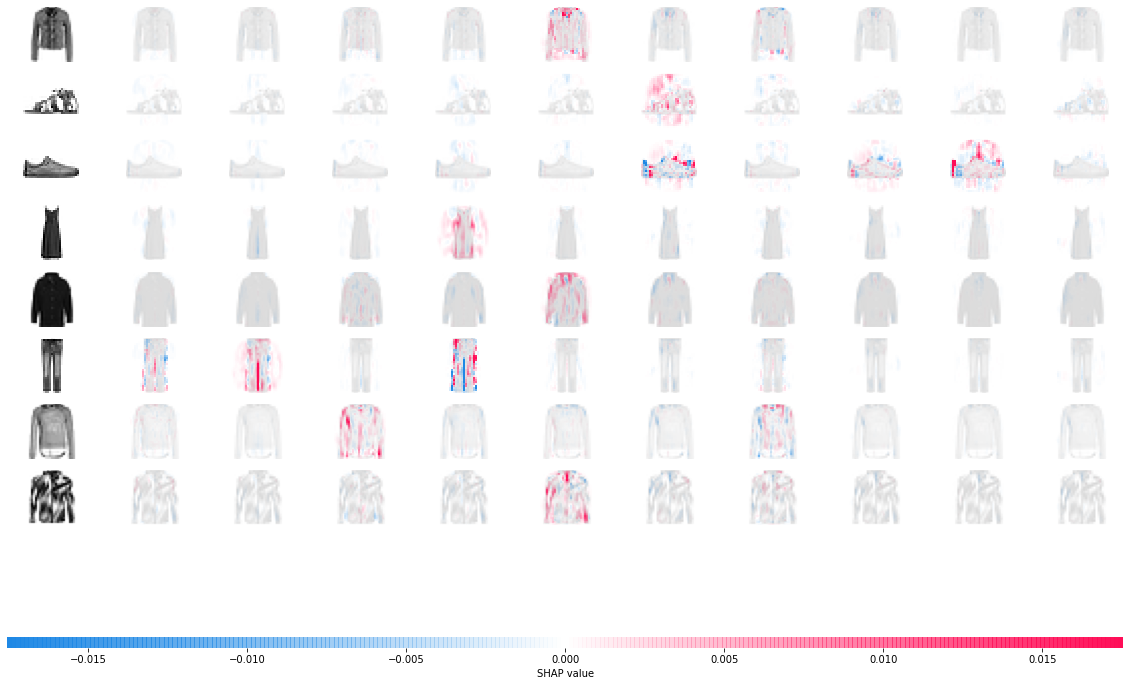

In [26]:
# plot the feature attributions
#labels = ['T-shirt/top', 'Trouser','Pullover','Dress','Coat','Sandal','Shirt','Sneaker','Bag','Ankle boot']
shap.image_plot(shap_values, -x_test[10:18])

In [28]:
y_test[10:18]

array([[0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]], dtype=float32)